# Import et Installation

In [ ]:
!pip install yfinance
!pip install requests pandas
import requests
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.stats import norm

# Définition des tickers, de la période voulue et des clés pour API

In [97]:
tickers = ["GOOG", "AAPL", "META", "MSFT", "AMZN", "TSLA", "NFLX"] # Définition (par leur ticker) des entreprises étudiées 

periode_d = 730 # Période d'interet en jour (2ans)

end_date = datetime.today()
start_date = end_date - timedelta(days=periode_d)
historical_date = end_date - timedelta(days=5*365) # Création d'une date antérieure plus ancienne utile dans les cas où l'historique ne contient pas suffisament de données

end_date = end_date.strftime('%Y-%m-%d')
start_date = start_date.strftime('%Y-%m-%d')
historical_date = historical_date.strftime('%Y-%m-%d')

all_dates = pd.date_range(start=historical_date, end=end_date) # Générer une liste de toutes les dates dans l'intervalle

api_key = "982c933ec445b467499f63f143e687f0" # Clé API du site de la Banque Fédérale de Saint Louis (Missouri, USA)

# Dividends

In [98]:
def get_dividend(ticker_name):
    ticker = yf.Ticker(ticker_name)

    dividends = ticker.dividends
    df_dividends = dividends.reset_index()
    df_dividends.columns = ["date", "dividend"]

    df_dividends['dividend'] = df_dividends['dividend'].astype(float)  # Conversion en float
    df_dividends['date'] = pd.to_datetime(df_dividends['date']).dt.strftime("%Y-%m-%d")
    df_dividends['date'] = pd.to_datetime(df_dividends['date']).dt.tz_localize(None) #Pour mettre les dates sous le même format que pour le sous-jacent

        # Permet de compléter l'historique dans le cas où des dates manqueraient dans le dataframe extrait
        # Pour cela nous rajoutons toutes les dates qui manquerait entre la date de début et la date de fin de l'intervalle d'interet puis si une date n'a pas de valeur associée, nous lui associons la dernière valeur connue
        # Nous pensons que cette démarche est réaliste car à l'instant t, chaque acteur connait les événements passés (ici les dividendes) mais pas les événements futures.
        # Ainsi par cela nous essayons de matérialiser les connaissances des acteurs sur les marchés à chaque instant
    df_dividends = (
        df_dividends.set_index("date")
        .reindex(all_dates)  # Ajouter les dates manquantes
        .fillna(method="ffill")  # Remplir avec la dernière valeur connue
        .reset_index()
    )

    df_dividends = df_dividends.rename(columns={"index": "Date"})
    df_dividends = df_dividends.rename(columns={"dividend": "Dividend"})
    df_dividends = df_dividends[df_dividends["Date"] >= start_date] # On restraint finalement l'intervalle de temps observé pour bien coincider avec l'intervalle d'intéret

    return df_dividends

# Sous-jacent

In [99]:
def get_sous_jacent(ticker_name) :
    ticker_symbol = ticker_name # Définition du ticker de l'action étudiée

    df_sous_jacent = yf.download(ticker_symbol, period='5y')

    # Aplatir les colonnes multi-niveaux
    df_sous_jacent.columns = ['_'.join(col).strip() for col in df_sous_jacent.columns] # Permet de ne plus avoir de colonnes multi_niveaux
    df_sous_jacent = df_sous_jacent.reset_index() # Pour mettre la date comme colonne
    df_sous_jacent["Sous_jacent"]=ticker_symbol
    df_sous_jacent = df_sous_jacent.sort_values(by="Date").reset_index(drop=True)

    columns =["Date",f"Close_{ticker_symbol}",f"Volume_{ticker_symbol}","Sous_jacent"]
    df_sous_jacent = df_sous_jacent[columns]

    df_sous_jacent = df_sous_jacent.rename(columns={f"Close_{ticker_symbol}": "Close_ss_jacent"})
    df_sous_jacent = df_sous_jacent.rename(columns={f"Volume_{ticker_symbol}": "Volume_ss_jacent"})


    df_sous_jacent["Close_yesterday_ss_jacent"] = df_sous_jacent["Close_ss_jacent"].shift(+1) # Création d'une nouvelle variable représentant le prix de l'action la veille (utile pour calculer la performance de l'action sur une journée)

    horizons = [2,5,21] # On va créer des moyennes glissantes des prix de l'action sur 2 jours, 1 semaine et 1 mois
    for horizon in horizons:
        # Calcul de la moyenne glissante sur l'horizon donné
        rolling_averages = df_sous_jacent["Close_ss_jacent"].rolling(horizon).mean() 
        
        # Générer le nom de la nouvelle colonne
        moy_column = f"mean_{horizon}d_ss_jacent"  
        
        # Ajouter la colonne avec les moyennes calculées à la dataframe
        df_sous_jacent[moy_column] = rolling_averages

    
    # Calcul des performances glissantes
    df_sous_jacent["Perf_1d_ss_jacent"] = df_sous_jacent["Close_ss_jacent"].pct_change(1)  # 1 jour
    df_sous_jacent["Perf_1w_ss_jacent"] = df_sous_jacent["Close_ss_jacent"].pct_change(5)  # 1 semaine (environ 5 jours ouvrés)
    df_sous_jacent["Perf_1m_ss_jacent"] = df_sous_jacent["Close_ss_jacent"].pct_change(21)  # 1 mois (environ 21 jours ouvrés)
    df_sous_jacent["Perf_3m_ss_jacent"] = df_sous_jacent["Close_ss_jacent"].pct_change(63)  # 3 mois (environ 63 jours ouvrés)
    df_sous_jacent["Perf_6m_ss_jacent"] = df_sous_jacent["Close_ss_jacent"].pct_change(126)  # 6 mois (environ 126 jours ouvrés)
    df_sous_jacent["Perf_1y_ss_jacent"] = df_sous_jacent["Close_ss_jacent"].pct_change(252)  # 1 an (environ 252 jours ouvrés)


    df_sous_jacent['Log_perf_1d_ss_jacent'] = np.log(df_sous_jacent["Close_ss_jacent"]/df_sous_jacent["Close_yesterday_ss_jacent"]) # Calcul des rendements logarithmiques quotidien (nécessaire pour calculer la volatilité du sous-jacent)
    df_sous_jacent["Volatility_1y_ss_jacent"] = df_sous_jacent['Log_perf_1d_ss_jacent'].rolling(window=30).std() * np.sqrt(252) # Calcul de la volatilité sur 30 jours annualisée
    df_sous_jacent["Global_volatility"] = np.sqrt((df_sous_jacent['Log_perf_1d_ss_jacent'].var())*252) # Calcul de la volatilité globale du sous-jacent sur tout l'historique (nécéssaire pour réaliser des prédictions avec le model de Black-Scholes)


    df_dividend = get_dividend(ticker_name)
    df_merged = pd.merge(df_sous_jacent, df_dividend, on='Date', how='inner')

    return df_merged

In [ ]:
for ticker in tickers:
    globals()[f"df_sous_jacent_{ticker}"] = get_sous_jacent(ticker)


# Option (call)

In [15]:
def get_option(ticker_name) :
    ticker = yf.Ticker(ticker_name)
    options_chain = []
    calls = []
    enriched_data =[]

    selected_expiration_dates = list(ticker.options) # Extraire toutes les dates de maturité des options disponibles sur le sous-jacent étudié

    for selected_expiration_date in selected_expiration_dates :
        options_chain.append(ticker.option_chain(selected_expiration_date)) # Récupération des informations les plus récentes sur chaque option

    for expiration_date, options in zip(selected_expiration_dates, options_chain):
        options.calls['Expiration Date'] = expiration_date # On associe à chaque call sa date de maturité
        calls.append(options.calls)

    # On va vouloir prendre l'historique pour tous les calls dans la liste `calls`
    for calls_df in calls:

        for _, call in calls_df.iterrows():  # Parcourt chaque ligne du DataFrame de calls
            contract_symbol = call['contractSymbol']  # Identifiant du call
            try:
                option = yf.Ticker(contract_symbol)

                # Récupérer l'historique des prix de chaque call
                history = option.history(
                    start=start_date,
                    end=end_date,
                    interval='1d'
                )

                # Ajouter les données historiques dans le format souhaité
                for date, row in history.iterrows():
                    enriched_row = call.copy()  # Copie les données de la ligne actuelle
                    enriched_row['Close_call'] = row['Close']  # Ajouter le prix observé
                    enriched_row['Date'] = date  # Ajouter la date de l'observation
                    enriched_data.append(enriched_row)
            except Exception as e:
                print(f"Erreur lors de la récupération de {contract_symbol}: {e}")

    df_call = pd.DataFrame(enriched_data)

    final_columns = ['contractSymbol', 'strike', 'bid', 'ask', 'Close_call', 'impliedVolatility', 'Date','Expiration Date']
    df_call = df_call[final_columns]

    # Mettre les dates sous le même format que pour le sous-jacent
    df_call['Date'] = pd.to_datetime(df_call['Date']).dt.strftime("%Y-%m-%d")
    df_call['Date'] = pd.to_datetime(df_call['Date']).dt.tz_localize(None)

    df_call = df_call.rename(columns={"contractSymbol": "Ticker_call"})
    df_call = df_call.rename(columns={"strike": "Strike_price"})
    df_call = df_call.rename(columns={"bid": "Bid_call"})
    df_call = df_call.rename(columns={"ask": "Ask_call"})
    df_call = df_call.rename(columns={"impliedVolatility": "Volatility_call"})
    df_call = df_call.rename(columns={"Expiration Date": "Maturity_date"})
    df_call["Spread_bid_ask_call"] = df_call["Ask_call"]-df_call["Bid_call"]
    df_call["Time_before_maturity"] = pd.to_datetime(df_call["Maturity_date"]) - df_call["Date"] # La date de maturité étant la meme à chaque période pour chaque call, nous nous intéressons finalement au nombre de jour qu'il reste avant l'échéance du call
    df_call["Time_before_maturity"] = df_call["Time_before_maturity"].dt.days.astype(float)
    del df_call["Maturity_date"]

    # On observe l'historique disponible pour chaque call et on conserve le 1er parmi ceux qui ont le plus d'historique
    grouped_data = df_call.groupby('Ticker_call').size().reset_index(name='count')
    max_count = grouped_data['count'].max()
    result = grouped_data[grouped_data['count'] == max_count]

    startswith_value = result['Ticker_call'].iloc[0]
    df_call = df_call[df_call['Ticker_call'].str.startswith(startswith_value)]

    return df_call

In [ ]:
for ticker in tickers:
    globals()[f"df_option_{ticker}"] = get_option(ticker)

# Taux sans risque / IPC / Chomage / PIB

In [101]:
# Fonction pour récupérer les données depuis l'API FRED
def get_fred_data(series_id, api_key):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json"
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        if "observations" in data:
            df = pd.DataFrame(data["observations"])
            df["date"] = pd.to_datetime(df["date"])
            df["value"] = pd.to_numeric(df["value"], errors="coerce")
            return df[["date", "value"]]
        else:
            print(f"Aucune donnée pour {series_id}")
            return None
    else:
        print(f"Erreur API pour {series_id}: {response.status_code}")
        return None

    df['date'] = pd.to_datetime(df['date']).dt.strftime("%Y-%m-%d")
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None) # Pour mettre les dates sous le même format que pour le sous-jacent
    

### Taux sans risque

In [ ]:
#Taux sans risque Francais
df_tx_sans_risque_Fr = get_fred_data("IRLTLT01EZM156N", api_key)
    # Combler les dates manquantes avec la dernière valeur connue
df_tx_sans_risque_Fr = (
    df_tx_sans_risque_Fr.set_index("date")
    .reindex(all_dates)
    .fillna(method="ffill")
    .reset_index()
)
df_tx_sans_risque_Fr = df_tx_sans_risque_Fr.rename(columns={"value": "Risk_free_rate_Fr"})
df_tx_sans_risque_Fr = df_tx_sans_risque_Fr.rename(columns={"index": "Date"})
df_tx_sans_risque_Fr = df_tx_sans_risque_Fr[df_tx_sans_risque_Fr["Date"] >= start_date]


#Taux sans risque Allemand
df_tx_sans_risque_Ge = get_fred_data("IRLTLT01DEM156N", api_key)
df_tx_sans_risque_Ge = (
    df_tx_sans_risque_Ge.set_index("date")
    .reindex(all_dates)
    .fillna(method="ffill")
    .reset_index()
)
df_tx_sans_risque_Ge = df_tx_sans_risque_Ge.rename(columns={"value": "Risk_free_rate_Ge"})
df_tx_sans_risque_Ge = df_tx_sans_risque_Ge.rename(columns={"index": "Date"})
df_tx_sans_risque_Ge = df_tx_sans_risque_Ge[df_tx_sans_risque_Ge["Date"] >= start_date]


#Taux sans risque Anglais
df_tx_sans_risque_Uk = get_fred_data("IRLTLT01GBM156N", api_key)
df_tx_sans_risque_Uk = (
    df_tx_sans_risque_Uk.set_index("date")
    .reindex(all_dates)
    .fillna(method="ffill")
    .reset_index()
)
df_tx_sans_risque_Uk = df_tx_sans_risque_Uk.rename(columns={"value": "Risk_free_rate_Uk"})
df_tx_sans_risque_Uk = df_tx_sans_risque_Uk.rename(columns={"index": "Date"})
df_tx_sans_risque_Uk = df_tx_sans_risque_Uk[df_tx_sans_risque_Uk["Date"] >= start_date]


#Taux sans risque Américain
df_tx_sans_risque_Usa = get_fred_data("DGS10", api_key)
df_tx_sans_risque_Usa = (
    df_tx_sans_risque_Usa.set_index("date")
    .reindex(all_dates)
    .fillna(method="ffill")
    .reset_index()
)
df_tx_sans_risque_Usa = df_tx_sans_risque_Usa.rename(columns={"value": "Risk_free_rate_Usa"})
df_tx_sans_risque_Usa = df_tx_sans_risque_Usa.rename(columns={"index": "Date"})
df_tx_sans_risque_Usa = df_tx_sans_risque_Usa[df_tx_sans_risque_Usa["Date"] >= start_date]

### IPC

In [103]:
df_inflation = get_fred_data("CPIAUCSL", api_key)

df_inflation = (
    df_inflation.set_index("date")
    .reindex(all_dates)
    .fillna(method="ffill")
    .reset_index()
)

df_inflation = df_inflation.rename(columns={"index": "Date"})
df_inflation = df_inflation.rename(columns={"value": "IPC_index"})
df_inflation = df_inflation[df_inflation["Date"] >= start_date]

print(df_inflation)
print(df_inflation.info())

           Date  IPC_index
1095 2022-12-24    298.812
1096 2022-12-25    298.812
1097 2022-12-26    298.812
1098 2022-12-27    298.812
1099 2022-12-28    298.812
...         ...        ...
1821 2024-12-19    316.441
1822 2024-12-20    316.441
1823 2024-12-21    316.441
1824 2024-12-22    316.441
1825 2024-12-23    316.441

[731 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 731 entries, 1095 to 1825
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       731 non-null    datetime64[ns]
 1   IPC_index  731 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.1 KB
None


/tmp/ipykernel_66012/1557717002.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill")  # Remplir avec la dernière valeur connue


### Chomage

In [104]:
df_chomage = get_fred_data("LNS14000024", api_key)

df_chomage = (
    df_chomage.set_index("date")
    .reindex(all_dates)
    .fillna(method="ffill")
    .reset_index()
)

df_chomage = df_chomage.rename(columns={"index": "Date"})
df_chomage = df_chomage.rename(columns={"value": "Unemployment_rate"})
df_chomage = df_chomage[df_chomage["Date"] >= start_date]

print(df_chomage.info())
print(df_chomage)

<class 'pandas.core.frame.DataFrame'>
Index: 731 entries, 1095 to 1825
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               731 non-null    datetime64[ns]
 1   Unemployment_rate  731 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.1 KB
None
           Date  Unemployment_rate
1095 2022-12-24                3.2
1096 2022-12-25                3.2
1097 2022-12-26                3.2
1098 2022-12-27                3.2
1099 2022-12-28                3.2
...         ...                ...
1821 2024-12-19                3.9
1822 2024-12-20                3.9
1823 2024-12-21                3.9
1824 2024-12-22                3.9
1825 2024-12-23                3.9

[731 rows x 2 columns]


/tmp/ipykernel_66012/313684840.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill")  # Remplir avec la dernière valeur connue


### PIB

In [111]:
df_pib_usa = get_fred_data("GDPC1", api_key)

df_pib_usa = (
    df_pib_usa.set_index("date")
    .reindex(all_dates)
    .fillna(method="ffill")
    .reset_index()
)

df_pib_usa = df_pib_usa.rename(columns={"index": "Date"})
df_pib_usa = df_pib_usa.rename(columns={"value": "GDP_Usa"})
df_pib_usa = df_pib_usa[df_pib_usa["Date"] >= start_date]

print(df_pib_usa)

           Date    GDP_Usa
1095 2022-12-24  22249.459
1096 2022-12-25  22249.459
1097 2022-12-26  22249.459
1098 2022-12-27  22249.459
1099 2022-12-28  22249.459
...         ...        ...
1821 2024-12-19  23400.294
1822 2024-12-20  23400.294
1823 2024-12-21  23400.294
1824 2024-12-22  23400.294
1825 2024-12-23  23400.294

[731 rows x 2 columns]


/tmp/ipykernel_66012/3062196233.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill")  # Remplir avec la dernière valeur connue


# Indices Boursier

In [106]:
eurotoxx50 = yf.Ticker("^STOXX50E")
sp500 = yf.Ticker("^GSPC")
dowjones = yf.Ticker("^DJI")
nasdaq = yf.Ticker("^IXIC")

df_eurotoxx50 = eurotoxx50.history(period="2y")
df_eurotoxx50.reset_index(inplace=True)
df_eurotoxx50 = df_eurotoxx50[["Date","Close"]]
df_eurotoxx50['Date'] = pd.to_datetime(df_eurotoxx50['Date']).dt.strftime("%Y-%m-%d")
df_eurotoxx50['Date'] = pd.to_datetime(df_eurotoxx50['Date']).dt.tz_localize(None) # Pour mettre les dates sous le même format que pour le sous-jacent
df_eurotoxx50 = df_eurotoxx50.rename(columns={"Close": "Euro_Stoxx_50_index"})

df_sp500 = sp500.history(period="2y")
df_sp500.reset_index(inplace=True)
df_sp500 = df_sp500[["Date","Close"]]
df_sp500['Date'] = pd.to_datetime(df_sp500['Date']).dt.strftime("%Y-%m-%d")
df_sp500['Date'] = pd.to_datetime(df_sp500['Date']).dt.tz_localize(None)
df_sp500 = df_sp500.rename(columns={"Close": "S&P_500_index"})

df_dowjones = dowjones.history(period="2y")
df_dowjones.reset_index(inplace=True)
df_dowjones = df_dowjones[["Date","Close"]]
df_dowjones['Date'] = pd.to_datetime(df_dowjones['Date']).dt.strftime("%Y-%m-%d")
df_dowjones['Date'] = pd.to_datetime(df_dowjones['Date']).dt.tz_localize(None)
df_dowjones = df_dowjones.rename(columns={"Close": "Dow_Jones_index"})

df_nasdaq = nasdaq.history(period="2y")
df_nasdaq.reset_index(inplace=True)
df_nasdaq = df_nasdaq[["Date","Close"]]
df_nasdaq['Date'] = pd.to_datetime(df_nasdaq['Date']).dt.strftime("%Y-%m-%d")
df_nasdaq['Date'] = pd.to_datetime(df_nasdaq['Date']).dt.tz_localize(None)
df_nasdaq = df_nasdaq.rename(columns={"Close": "Nasdaq_index"})

print(df_eurotoxx50)

          Date  Euro_Stoxx_50_index
0   2022-12-23          3817.010010
1   2022-12-27          3832.889893
2   2022-12-28          3808.820068
3   2022-12-29          3850.070068
4   2022-12-30          3793.620117
..         ...                  ...
499 2024-12-17          4942.580078
500 2024-12-18          4957.279785
501 2024-12-19          4879.000000
502 2024-12-20          4862.279785
503 2024-12-23          4861.000000

[504 rows x 2 columns]


# VIX

In [107]:
vix = yf.Ticker("^VIX")

df_vix = vix.history(period="2y")
df_vix.reset_index(inplace=True)
df_vix = df_vix[["Date","Close"]]
df_vix['Date'] = pd.to_datetime(df_vix['Date']).dt.strftime("%Y-%m-%d")
df_vix['Date'] = pd.to_datetime(df_vix['Date']).dt.tz_localize(None) # Pour mettre les dates sous le même format que pour le sous-jacent
df_vix = df_vix.rename(columns={"Close": "VIX_index"})

print(df_vix)

          Date  VIX_index
0   2022-12-23  20.870001
1   2022-12-27  21.650000
2   2022-12-28  22.139999
3   2022-12-29  21.440001
4   2022-12-30  21.670000
..         ...        ...
497 2024-12-17  15.870000
498 2024-12-18  27.620001
499 2024-12-19  24.090000
500 2024-12-20  18.360001
501 2024-12-23  18.860001

[502 rows x 2 columns]


# Concaténation de tous les DataFrames

In [110]:
# Nous mettons essemble les informations de chaque entreprise étudiée avec le call extrait correspondant
df_GOOG = pd.merge(df_sous_jacent_GOOG, df_option_GOOG, on='Date', how='inner')
df_AAPL = pd.merge(df_sous_jacent_AAPL, df_option_AAPL, on='Date', how='inner')
df_META = pd.merge(df_sous_jacent_META, df_option_META, on='Date', how='inner')
df_MSFT = pd.merge(df_sous_jacent_MSFT, df_option_MSFT, on='Date', how='inner')
df_AMZN = pd.merge(df_sous_jacent_AMZN, df_option_AMZN, on='Date', how='inner')
df_TSLA = pd.merge(df_sous_jacent_TSLA, df_option_TSLA, on='Date', how='inner')
df_NFLX = pd.merge(df_sous_jacent_NFLX, df_option_NFLX, on='Date', how='inner')

df = pd.concat([df_GOOG, df_AAPL, df_META, df_MSFT, df_AMZN, df_TSLA, df_NFLX], ignore_index=True) # Nous ajoutons le dataframe de chaque entreprise les uns en dessous des autres pour consistuer notre base de donnée

# Nous associons à chaque date les informations (dataframes) extraites précédement
to_merge=[df_tx_sans_risque_Fr, df_tx_sans_risque_Ge, df_tx_sans_risque_Uk, df_tx_sans_risque_Usa, df_eurotoxx50, df_sp500, df_dowjones, df_nasdaq, df_vix, df_inflation, df_chomage, df_pib_usa]
for df_to_merge in to_merge:
    df = pd.merge(df, df_to_merge, on='Date', how='left')

df = df.sort_values(by ="Date", ascending=True)

df["Date_x_Sous_jacent"] = list(zip(df["Date"], df["Sous_jacent"])) # Création d'un tuple (Date, Sous-jacent) qui nous permet de dissocier chaque série temporelle et d'observer leur évolution en fonction de la date
del df["Date"]
del df["Sous_jacent"]

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 529 entries, 0 to 528
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Close_ss_jacent            529 non-null    float64
 1   Volume_ss_jacent           529 non-null    int64  
 2   Close_yesterday_ss_jacent  529 non-null    float64
 3   mean_2d_ss_jacent          529 non-null    float64
 4   mean_5d_ss_jacent          529 non-null    float64
 5   mean_21d_ss_jacent         529 non-null    float64
 6   Perf_1d_ss_jacent          529 non-null    float64
 7   Perf_1w_ss_jacent          529 non-null    float64
 8   Perf_1m_ss_jacent          529 non-null    float64
 9   Perf_3m_ss_jacent          529 non-null    float64
 10  Perf_6m_ss_jacent          529 non-null    float64
 11  Perf_1y_ss_jacent          529 non-null    float64
 12  Log_perf_1d_ss_jacent      529 non-null    float64
 13  Volatility_1y_ss_jacent    529 non-null    float64
 14 

# Identification des valeurs manquantes

In [78]:
# Nous voulons identifier quelles sont les variables qui ont des valeurs manquantes
# Dans les modeles développés par la suite, nous utiliserons la méthode des proches voisins lorsque ceci représente peu de valeurs et est lié simplement à une information non existante
missing_values = df.isnull().sum()
columns_with_missing = missing_values[missing_values > 0] # Filtrer pour ne garder que les colonnes avec des valeurs nulles

print(columns_with_missing)

Dividend         30
Euro_Stoxx_50    11
dtype: int64


# Black-Scholes Prediction

In [79]:
# Définition des dernières variables utiles pour le model de Black-Scholes et prédiction
df["d1"] = (np.log(df["Close_ss_jacent"]/df["Strike_price"])+((df["Time_before_maturity"]/365)*((df["Taux_sans_risque_Usa"]/100)+((df["Global_volatility"]**2)/2))))/(df["Global_volatility"]*np.sqrt(df["Time_before_maturity"]/365))
df["d2"] = df["d1"] - df["Global_volatility"]*np.sqrt(df["Time_before_maturity"]/365)

df["Call_price_BS"] = df["Close_ss_jacent"]*norm.cdf(df["d1"]) - df["Strike_price"]*np.exp(-(df["Taux_sans_risque_Usa"]/100)*df["Time_before_maturity"]/365)*norm.cdf(df["d2"])

del df["d1"]
del df["d2"]

# Création du document CSV contenant notre base de données

In [ ]:
df.to_csv('data.csv', index=False)

# Illustration des prédictions avec le modèle de Black-Scholes

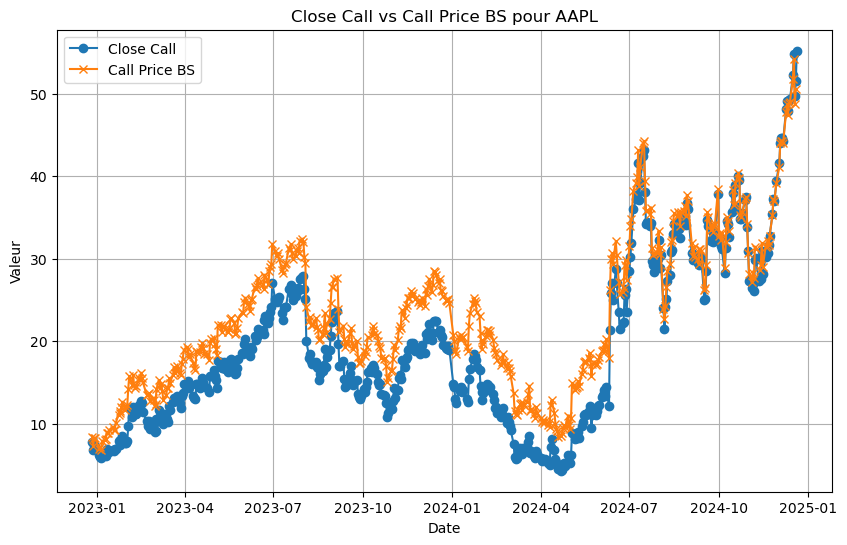

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extraire les colonnes 'date' et 'sous_jacent'
df["Date"] = df["Date_x_Sous_jacent"].apply(lambda x: x[0])  # Extraire la date
df["Sous_jacent"] = df["Date_x_Sous_jacent"].apply(lambda x: x[1])  # Extraire le sous-jacent

# Convertir la colonne 'date' en datetime pour une meilleure gestion
df["Date"] = pd.to_datetime(df["Date"])

# Filtrer les données pour le sous-jacent AAPL
df_aapl = df[df["Sous_jacent"] == "AAPL"]

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(df_aapl["Date"], df_aapl["Close_call"], label="Close Call", marker="o")
plt.plot(df_aapl["Date"], df_aapl["Call_price_BS"], label="Call Price BS", marker="x")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.title("Close Call vs Call Price BS pour AAPL")
plt.legend()
plt.grid()
plt.show()